In [36]:
import json
import os
import pickle
import yaml

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from src.preprocessing.old_utils import evaluate
from src.preprocessing.preprocessing import get_Xy_from_sheet, spacy_preprocess_texts
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)
model_save_path = config["model_save_path"]
result_save_path = config["result_save_path"]

preproc = config["preprocessing"]["type"]

data_path = config["data_path"]
results_prefix = './test/results/'



# Create DataFrame and new column for analysis
X, y = get_Xy_from_sheet(data_path, X_col='Original article text', y_col='Verdict')

# x_transform, nlp = spacy_preprocess_texts(X, 'test1', 'md')

# vectors = [nlp.vocab.vectors.key2row[word.norm] if word.has_vector and word.norm in nlp.vocab.vectors.key2row else None for word in x_transform[0]]
# print(vectors)
# print(nlp.vocab.vectors.key2row)

# Preprocessing TODO: 
# n-gram

# spacy preprocessing: lemma, stem, etc
# Remove punct, nums

# Find way to incorporate sentence structure
# Include parts of speech


if config['preprocessing']['type'] == 'tfidf':
    tfidf = TfidfVectorizer(ngram_range=(config['preprocessing']['ngram_min'], config['preprocessing']['ngram_max']))
    X_transform = tfidf.fit_transform(X)

    idx2word = {idx: word for word, idx in tfidf.vocabulary_.items()}

else:
    cv = CountVectorizer(ngram_range=(config['preprocessing']['ngram_min'], config['preprocessing']['ngram_max']))
    X_transform = cv.fit_transform(X)

    idx2word = {idx: word for word, idx in cv.vocabulary_.items()}

X_train, X_test, y_train, y_test = train_test_split(X_transform, y, shuffle=True, random_state=42)


models = {
    'logistic-regression': LogisticRegression(),
    'svm': SVC(kernel='linear'),
    'decision-tree': DecisionTreeClassifier(),
    'random-forest': RandomForestClassifier(),
}

# LogReg, Decision Trees, Random Forests, SVMs

dataset_name = data_path.split('.')[0].split('/')[-1]

for model_name, model in models.items():
    fname = dataset_name + '_' + model_name
    pklname = model_save_path + fname + '.pkl'

    if pklname not in os.listdir(model_save_path):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        pickle.dump(model, open(pklname, 'wb'))

    else:
        model = pickle.load(open(pklname, 'rb'))
    print(model_name)
    acc, prec, recall = evaluate(y_test, preds)

    if model_name in ['logistic-regression', 'svm']:
        coefs = model.coef_[0]
        if model_name == 'svm':
            coefs = coefs.toarray().reshape((-1,))
        

    elif model_name in ['decision-tree', 'random-forest']:
        coefs = model.feature_importances_

    coefs = [(coef, i) for i, coef in enumerate(coefs)]
    coefs.sort(key=lambda x: x[0] ** 2, reverse=True)

    num_words = config['output']['num_words']
    most_important_words = {idx2word[idx]: coef for coef, idx in coefs[:num_words]}

    if config['output']['print']: print(f'Most important words for {model_name}: {most_important_words}')

    resultname = result_save_path + fname + '_' + preproc + '.json'
    with open(resultname, 'w') as f:
        json.dump(most_important_words, f)



logistic-regression
              precision    recall  f1-score   support

       False       0.83      0.33      0.48        15
        True       0.47      0.90      0.62        10

    accuracy                           0.56        25
   macro avg       0.65      0.62      0.55        25
weighted avg       0.69      0.56      0.53        25

Accuracy score: 0.56
Precision score: 0.47368421052631576
Recall score: 0.9
svm
              precision    recall  f1-score   support

       False       0.83      0.33      0.48        15
        True       0.47      0.90      0.62        10

    accuracy                           0.56        25
   macro avg       0.65      0.62      0.55        25
weighted avg       0.69      0.56      0.53        25

Accuracy score: 0.56
Precision score: 0.47368421052631576
Recall score: 0.9
decision-tree
              precision    recall  f1-score   support

       False       0.69      0.73      0.71        15
        True       0.56      0.50      0.53    

In [23]:
most_important_words

{'not': 0.012153092870731678,
 'more': 0.011188979699728579,
 'can': 0.010033007368275719,
 'been': 0.009635649952974923,
 'feb': 0.008045075834568594,
 '16': 0.007934274877752823,
 'half': 0.007881210759705904,
 'when': 0.007071649512518184,
 'based': 0.006738504222246431,
 'at': 0.006515346401069509,
 'center': 0.006475129121701783,
 'than': 0.006459258509435791,
 'what': 0.0060713478521683475,
 'miles': 0.005928273396341994,
 'away': 0.005837301429418387,
 'company': 0.005525329235100327,
 'take': 0.005279088228578266,
 'had': 0.005276782417306142,
 'be': 0.005239621570683864,
 'before': 0.005154346487588914,
 'up': 0.004832525459033413,
 'either': 0.0047850345571807,
 'also': 0.00477578757164607,
 'month': 0.004624044687906193,
 'top': 0.004524662339844283,
 'was': 0.0044805224222284265,
 'full': 0.004347027023618758,
 '10': 0.004312426566339907,
 'change': 0.0042548691454367925,
 'has': 0.0042270005066981624,
 'each': 0.004135661716830548,
 'all': 0.004127281207847663,
 'by': 0.00

In [6]:
import wordcloud

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

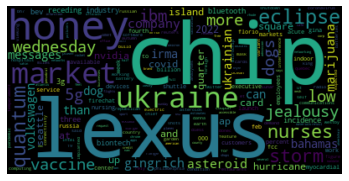

In [61]:
import matplotlib.pyplot as plt
f = open("results/science_logistic-regression_tfidf.json")
most_important_words = json.load(f)
wc = WordCloud()
wc.generate_from_frequencies(most_important_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig("results/Figures/science_logisitic_cloud.png")
plt.show()


In [31]:
#makes intersection of sets, select two topics, what preprocessing, and what model
def topicintersection (topic1, topic2, preproc, model):
    f = open("results/"+ topic1 + "_" + model + "_"  + preproc + ".json")
    set1 = set(json.load(f).keys())
    f2 = open("results/"+ topic2 + "_" + model + "_"  + preproc + ".json")
    set2 = set(json.load(f2).keys()) 
    pct_intersect = len(set1.intersection(set2))/len(set2)
    return pct_intersect

In [32]:
topicintersection("economics", "politics", "tfidf", "logistic-regression")

0.158

In [53]:
#runs topicintersection for all topics and models, (atm just for tfidf and logistic)
def intersect_all():
    intersections = {}
    for topic in ["general","politics", "economics", "science"]:
        intersections[topic] = {}
        for topic2 in ["general","politics", "economics", "science"]:
            if topic == topic2:
                pass
            else:
                pct_intersect = topicintersection(topic, topic2, 'tfidf', "logistic-regression")
                intersections[topic][topic2 + ", tfidf, " +"logistic-regression"] = pct_intersect
    return intersections


In [54]:
intersections

{'general': {'politics, tfidf, logistic-regression': 0.322,
  'economics, tfidf, logistic-regression': 0.386,
  'science, tfidf, logistic-regression': 0.314},
 'politics': {'general, tfidf, logistic-regression': 0.322,
  'economics, tfidf, logistic-regression': 0.158,
  'science, tfidf, logistic-regression': 0.132},
 'economics': {'general, tfidf, logistic-regression': 0.386,
  'politics, tfidf, logistic-regression': 0.158,
  'science, tfidf, logistic-regression': 0.132},
 'science': {'general, tfidf, logistic-regression': 0.314,
  'politics, tfidf, logistic-regression': 0.132,
  'economics, tfidf, logistic-regression': 0.132}}

In [56]:
topicintersection("science", "economics", "tfidf", "logistic-regression")

0.132